In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    from pdtr import ParseDecisionTreeRules
except ModuleNotFoundError:
    import sys
    
    sys.path.append("../")
    from pdtr import ParseDecisionTreeRules
    
np.random.seed(1)

In [2]:
# !pip install -r ../requirements.txt -U

In [3]:
feature_map = {}
n_samples = 10000
ab = np.array(list('ABCDEFG'))

data = pd.DataFrame({
    'A': np.random.randint(10, size = n_samples),
    'B': ab[np.random.choice(7, n_samples)],
    'C': ab[np.random.choice(2, n_samples)],
    'D': np.random.random(size = n_samples),
    'target': np.random.randint(2, size = n_samples)
})

train, test = train_test_split(data, test_size=0.3, shuffle=data["target"])

,组合策略,命中数,命中率,好样本数,好样本占比,坏样本数,坏样本占比,坏率,样本整体坏率,LIFT值
0,D > 0.999 & A <= 6.5,7,0.0010,7,0.0019,0,0.0000,0.0000,0.4863,0.0000
1,D <= 0.999 & D <= 0.999,6986,0.9980,3589,0.9981,3397,0.9979,0.4863,0.4863,0.9999
2,D <= 0.999 & D > 0.999,6,0.0009,0,0.0000,6,0.0018,1.0000,0.4863,2.0564
3,D > 0.999 & A > 6.5,1,0.0001,0,0.0000,1,0.0003,1.0000,0.4863,2.0564


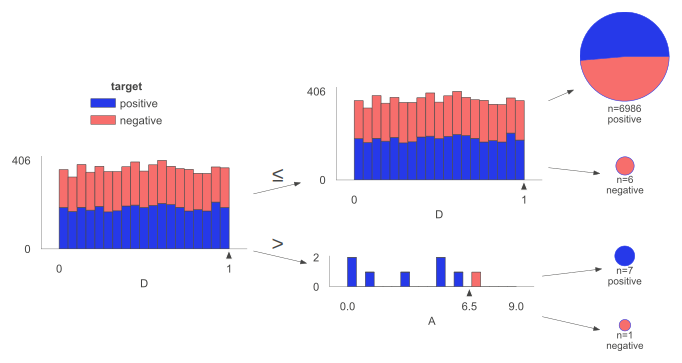

,组合策略,命中数,命中率,好样本数,好样本占比,坏样本数,坏样本占比,坏率,样本整体坏率,LIFT值
0,C <= 0.486 & B <= 0.483,1552,0.2217,832,0.2314,720,0.2115,0.4639,0.4863,0.9540
1,C > 0.486 & B <= 0.499,3026,0.4323,1543,0.4291,1483,0.4357,0.4901,0.4863,1.0078
2,C <= 0.486 & B > 0.483,1967,0.2810,1002,0.2786,965,0.2835,0.4906,0.4863,1.0089
3,C > 0.486 & B > 0.499,455,0.0650,219,0.0609,236,0.0693,0.5187,0.4863,1.0666


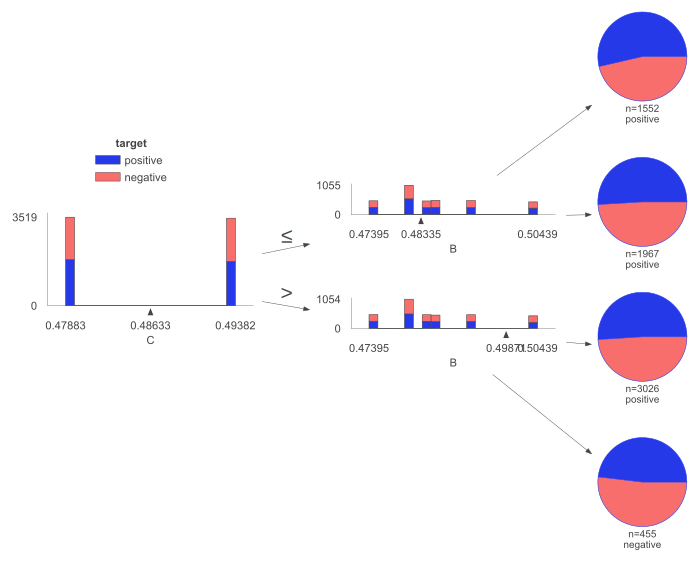

,组合策略,命中数,命中率,好样本数,好样本占比,坏样本数,坏样本占比,坏率,样本整体坏率,LIFT值
0,A <= 5.5 & A > 3.5,1451,0.2073,769,0.2138,682,0.2004,0.4700,0.4863,0.9666
1,A <= 5.5 & A <= 3.5,2770,0.3957,1431,0.3979,1339,0.3934,0.4834,0.4863,0.9941
2,A > 5.5 & C <= 0.486,1404,0.2006,718,0.1997,686,0.2015,0.4886,0.4863,1.0048
3,A > 5.5 & C > 0.486,1375,0.1964,678,0.1885,697,0.2048,0.5069,0.4863,1.0424


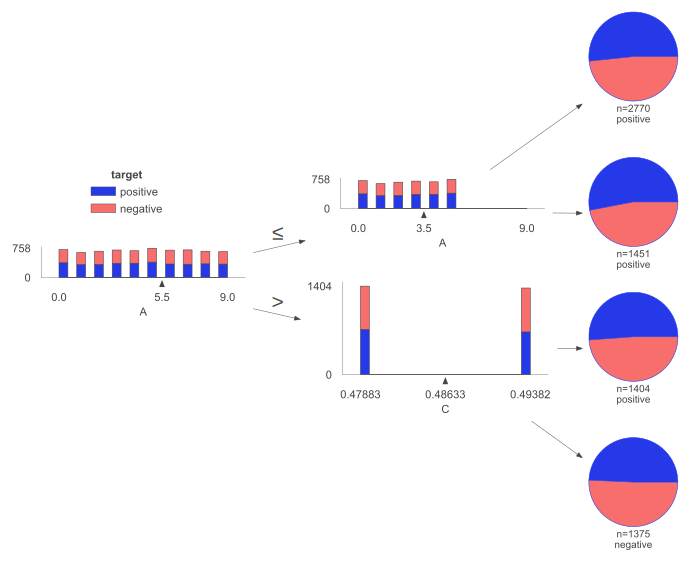

In [4]:
pdtr_instance = ParseDecisionTreeRules(target="target", max_iter=8)
pdtr_instance.fit(train, lift=0., max_depth=2, max_samples=1., verbose=True, max_features="auto")
all_rules = pdtr_instance.insert_all_rules(test=test)
pdtr_instance.save()

In [5]:
all_rules[0]

,组合策略,命中数,命中率,好样本数,好样本占比,坏样本数,坏样本占比,坏率,样本整体坏率,LIFT值
0,D > 0.999 & A <= 6.5,7,0.0010,7,0.0019,0,0.0000,0.0000,0.4863,0.0000
1,D <= 0.999 & D <= 0.999,6986,0.9980,3589,0.9981,3397,0.9979,0.4863,0.4863,0.9999
2,D <= 0.999 & D > 0.999,6,0.0009,0,0.0000,6,0.0018,1.0000,0.4863,2.0564
3,D > 0.999 & A > 6.5,1,0.0001,0,0.0000,1,0.0003,1.0000,0.4863,2.0564
4,C <= 0.486 & B <= 0.483,1552,0.2217,832,0.2314,720,0.2115,0.4639,0.4863,0.9540
5,C > 0.486 & B <= 0.499,3026,0.4323,1543,0.4291,1483,0.4357,0.4901,0.4863,1.0078
6,C <= 0.486 & B > 0.483,1967,0.2810,1002,0.2786,965,0.2835,0.4906,0.4863,1.0089
7,C > 0.486 & B > 0.499,455,0.0650,219,0.0609,236,0.0693,0.5187,0.4863,1.0666
8,A <= 5.5 & A > 3.5,1451,0.2073,769,0.2138,682,0.2004,0.4700,0.4863,0.9666
9,A <= 5.5 & A <= 3.5,2770,0.3957,1431,0.3979,1339,0.3934,0.4834,0.4863,0.9941


In [6]:
all_rules[1]

,组合策略,命中数,命中率,好样本数,好样本占比,坏样本数,坏样本占比,坏率,样本整体坏率,LIFT值
0,D > 0.999 & A <= 6.5,1,0.0003,0,0.0000,1,0.0007,1.0000,0.4867,2.0548
1,D <= 0.999 & D <= 0.999,2999,0.9997,1540,1.0000,1459,0.9993,0.4865,0.4867,0.9996
2,D <= 0.999 & D > 0.999,0,0.0000,0,0.0000,0,0.0000,0.0000,0.4867,0.0000
3,D > 0.999 & A > 6.5,0,0.0000,0,0.0000,0,0.0000,0.0000,0.4867,0.0000
4,C <= 0.486 & B <= 0.483,666,0.2220,328,0.2130,338,0.2315,0.5075,0.4867,1.0428
5,C > 0.486 & B <= 0.499,1282,0.4273,667,0.4331,615,0.4212,0.4797,0.4867,0.9857
6,C <= 0.486 & B > 0.483,847,0.2823,441,0.2864,406,0.2781,0.4793,0.4867,0.9849
7,C > 0.486 & B > 0.499,205,0.0683,104,0.0675,101,0.0692,0.4927,0.4867,1.0124
8,A <= 5.5 & A > 3.5,604,0.2013,319,0.2071,285,0.1952,0.4719,0.4867,0.9696
9,A <= 5.5 & A <= 3.5,1162,0.3873,591,0.3838,571,0.3911,0.4914,0.4867,1.0097


In [7]:
# %matplotlib inline

# import matplotlib.pyplot as plt


# for col in data.columns.drop("target"):
#     feature_table_train = pdtr_instance.query_feature_rule(train, col, desc="训练数据集", ks=True, min_bin_size=0.15, max_bin_size=3, method="dt")
#     feature_table_test = pdtr_instance.query_feature_rule(test, col, desc="测试数据集", ks=True, rules=pdtr_instance.combiner.rules[col])
#     display(feature_table_train)
#     display(feature_table_test)
#     fig = pdtr_instance.bin_plot(feature_table_train, desc=col, save=f"model_report/bin_plots/bin_vars_{col}.png")
#     plt.show()
    
#     # train_feature_table = pdtr_instance.query_feature_rule(data, col, desc="单变量策略挖掘", bin_plot=True, ks=True, min_bin_size=0.15, max_bin_size=3, method="dt")
#     # display(train_feature_table)